In [6]:
# clasificacion de espectros 

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt


filepath0 = 'C:/Users/erick/Documents/balanced_spectra_features.csv'

df_spectra = pd.read_csv(filepath0)
print("CSV columns:", df_spectra.columns.tolist())

print(df_spectra.tail())
df_spectra[df_spectra['spectype']=='GALAXY']
df_spectra[df_spectra['spectype']=='STAR']

filepath='C:/Users/erick/Documents/balanced_spectra_flux.npz'
data = np.load(filepath, allow_pickle=True)
targetids = data['targetids']
flux_arrays = data['flux_arrays']

flux_dict = {tid: flux for tid, flux in zip(targetids, flux_arrays)}
print(f"Loaded {len(flux_dict)} spectra from {filepath}")






CSV columns: ['targetid', 'survey', 'program', 'desi_target', 'z', 'zwarn', 'spectype', 'desiname', 'specid', 'redshift']
              targetid survey program          desi_target         z  zwarn  \
487  39628031613995781   main    dark  4611686018427650052  1.132489      0   
488  39627689362983081   main    dark  4611686018428829830  0.870082      0   
489  39627474228742564   main    dark  4611686018428829830  1.057718      0   
490  39627812356756299   main    dark  4611686018427650052  1.293974      0   
491  39627869730643820   main    dark  6917529027641344004  0.777878      0   

    spectype                desiname        specid  redshift  
487   GALAXY  DESI J020.5016+10.2330  3.962803e+16  1.132489  
488   GALAXY  DESI J073.9506-03.9645  3.962769e+16  0.870082  
489   GALAXY  DESI J065.4778-12.9870  3.962747e+16  1.057718  
490      QSO  DESI J206.9822+01.0158  3.962781e+16  1.293974  
491      QSO  DESI J027.2577+03.5412  3.962787e+16  0.777878  
Loaded 492 spectra from C

Shapes: (100, 7781) (100,)
Escalado completado: (70, 7781)
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.5357 - loss: 0.9805 - val_accuracy: 0.8571 - val_loss: 0.4256
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7321 - loss: 1.1244 - val_accuracy: 0.9286 - val_loss: 0.4740
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7500 - loss: 0.9787 - val_accuracy: 0.8571 - val_loss: 0.4133
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7321 - loss: 1.2290 - val_accuracy: 0.8571 - val_loss: 0.2685
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7500 - loss: 1.2385 - val_accuracy: 0.8571 - val_loss: 0.2830
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7321 - loss: 0.7667 - val_accuracy: 0.8571 - val_loss: 0.3103
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6964 - loss: 0.8519 - val_accuracy: 0.8571 - val_loss: 0.2841
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accura

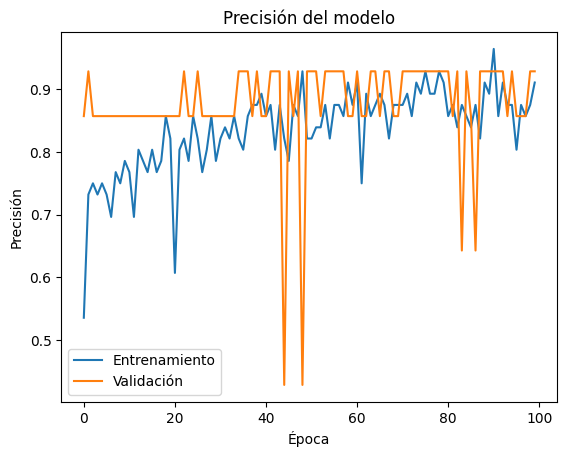

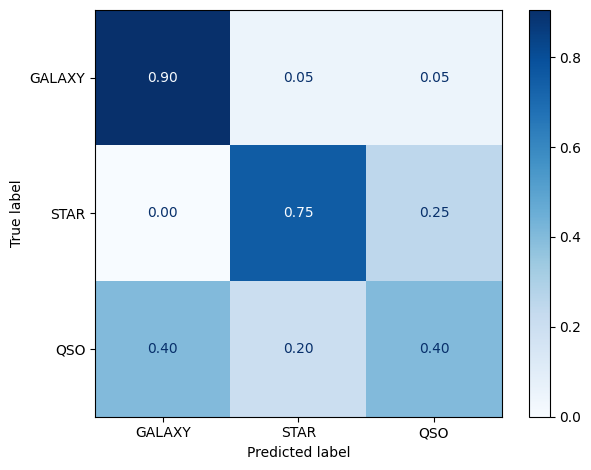

In [7]:
# clasificacion de espectros 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



X = []
Y = []


for i in range(len(targetids[0:100])):  # primeros 100 para prueba
    spectype = df_spectra.loc[df_spectra['targetid'] == targetids[i], 'spectype'].values[0]
    if spectype:
        if spectype == 'GALAXY':
            Y.append(0)
        elif spectype == 'STAR':
            Y.append(1)
        elif spectype == 'QSO':
            Y.append(2)
        else:
            print(f"spectype for TID:{spectype} not accepted")
            continue
    else:
        print(f"No spectype for TID:{targetids[i]}")
        continue
    X.append(data['flux_arrays'][i])

X = np.asarray(X)
Y = np.asarray(Y)

print("Shapes:", X.shape, Y.shape)


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=112)

original_shape = X_train.shape[1:]
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

print("Escalado completado:", X_train_scaled.shape)




model = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')  
])


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train_scaled.shape[1],)))

    
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(layers.Dense(
            units=hp.Int(f"units_{i}", min_value=32, max_value=256, step=32),
            activation="relu"
        ))
        model.add(layers.Dropout(
            rate=hp.Float(f"dropout_{i}", 0.0, 0.5, step=0.1)
        ))

    model.add(layers.Dense(3, activation="softmax"))

    opt_choice = hp.Choice("optimizer", ["adam", "rmsprop"])
    lr = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")

    if opt_choice == "adam":
        optimizer = keras.optimizers.Adam(learning_rate=lr)
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=lr)

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model



history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    verbose=1
)


test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f"\nAccuracy en test: {test_acc:.3f}")

y_pred = np.argmax(model.predict(X_test_scaled), axis=1)


f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)


plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Precisión del modelo')
plt.legend()
plt.show()


cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['GALAXY', 'STAR', 'QSO'])
disp.plot(cmap='Blues', values_format='.2f')
plt.tight_layout()
plt.show()


Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - loss: 79.7867 - mae: 4.0341 - val_loss: 72.0688 - val_mae: 4.9129
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 34.4856 - mae: 2.6604 - val_loss: 1.2590 - val_mae: 0.9183
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 1.2203 - mae: 0.8793 - val_loss: 0.6088 - val_mae: 0.5937
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 1.4135 - mae: 0.9529 - val_loss: 4.6852 - val_mae: 1.5629
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 11.5224 - mae: 1.9198 - val_loss: 15.2666 - val_mae: 3.2929
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 10.9232 - mae: 2.4361 - val_loss: 3.9487 - val_mae: 1.6639
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 3.4914 - mae: 1.4417 - val_loss: 1.9467 - val_mae: 1.2247
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 2.4552 - mae: 1.2489 - val_loss: 1.6764 - val_mae: 1.0893
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 2.2366 

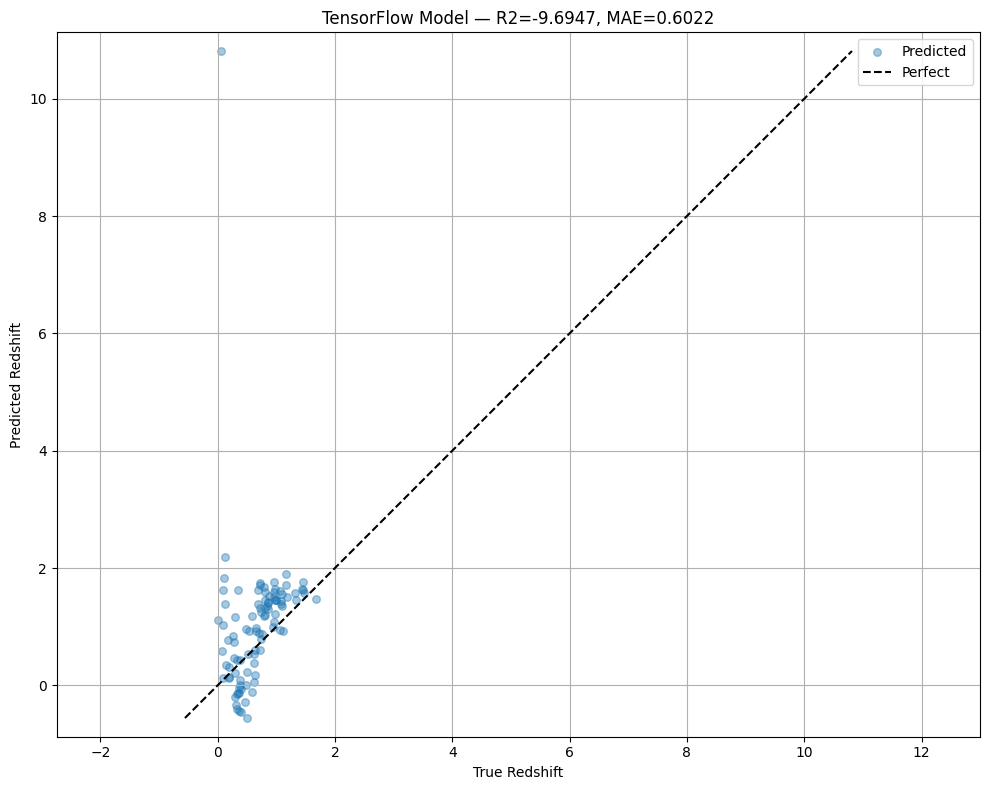

In [9]:
#determinación del corrimiento al rojo

X=[]
Y=[]
for i in range(len(targetids)):
  spectype = df_spectra.loc[df_spectra['targetid'] == targetids[i], 'spectype'].values[0]
  
  if spectype:
    if spectype == 'GALAXY':
       Y.append(df_spectra.loc[df_spectra['targetid'] == targetids[i], 'z'].values[0])
 
       X.append(data['flux_arrays'][i])

X=np.asarray(X)
Y=np.asarray(Y)




from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models


X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=112
)


X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

input_dim = X_train_scaled.shape[1]


def build_regression_model(hp):
    model = keras.Sequential()

    model.add(layers.Input(shape=(input_dim,)))

    
    num_layers = hp.Int("num_layers", 2, 5)

    for i in range(num_layers):
        units = hp.Int(f"units_{i}", min_value=64, max_value=512, step=64)
        dropout = hp.Float(f"dropout_{i}", 0.0, 0.5, step=0.1)

        model.add(layers.Dense(units, activation="relu"))
        model.add(layers.Dropout(dropout))

    
    model.add(layers.Dense(1))

    
    lr = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
    optimizer_name = hp.Choice("optimizer", ["adam", "rmsprop"])

    if optimizer_name == "adam":
        optimizer = keras.optimizers.Adam(learning_rate=lr)
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=lr)

    model.compile(
        optimizer=optimizer,
        loss="mse",
        metrics=["mae"]
    )

    return model

model_tf = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)     # salida continua: redshift
])

model_tf.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae']
)

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model_tf.fit(
    X_train_scaled, y_train,
    validation_split=0.15,
    epochs=200,
    batch_size=64,
    callbacks=[callback],
    verbose=1
)

y_pred_tf = model_tf.predict(X_test_scaled).flatten()

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

mse = mean_squared_error(y_test, y_pred_tf)
r2 = r2_score(y_test, y_pred_tf)
mae = mean_absolute_error(y_test, y_pred_tf)

print("\n" + "="*60)
print("TENSORFLOW REGRESSION SUMMARY")
print("="*60)
print(f"R2 = {r2:.4f}")
print(f"MSE = {mse:.6f}")
print(f"MAE = {mae:.6f}")

plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_tf, alpha=0.4, s=30, label='Predicted')

min_val = min(min(y_test), min(y_pred_tf))
max_val = max(max(y_test), max(y_pred_tf))

plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect')

plt.xlabel("True Redshift")
plt.ylabel("Predicted Redshift")
plt.title(f"TensorFlow Model — R2={r2:.4f}, MAE={mae:.4f}")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()
